In [47]:
import torch.nn.functional as F
import torch
from GridMLM_tokenizers import GuidedGridMLMTokenizer
from models import GuidedMLMH
from generate_utils import load_model
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import os
import csv

In [48]:
results_folder = 'results/experiments/'

curricula = ['random', 'base2']
subfolders = ['unf_CA', 'disentangle/unf_CA']
ablations = ['all', 'kl', 'rec', 'con']

device_name = 'cuda:2'

curriculum_type = curricula[0]
subfolder = subfolders[0]
ablation = ablations[0]

tokenizer = GuidedGridMLMTokenizer(fixed_length=256)
model = load_model(
        curriculum_type=curriculum_type,
        subfolder=subfolder,
        ablation=ablation,
        device_name=device_name,
        tokenizer=tokenizer
)
device = model.device

In [49]:
pickles_folder = '/media/maindisk/data/hooktheory_hr/guidance_experiment_data/'
files = os.listdir(pickles_folder)
print(files)

['unf_CA_random_all_test_test.pickle', 'unf_CA_base2_kl_jazz_jazz.pickle', 'unf_CA_random_rec_test_test.pickle', 'unf_CA_random_kl_test_jazz.pickle', 'disentangle_unf_CA_random_con_jazz_jazz.pickle', 'disentangle_unf_CA_random_all_jazz_test.pickle', 'unf_CA_random_con_test_test.pickle', 'unf_CA_base2_kl_test_jazz.pickle', 'unf_CA_base2_con_test_test.pickle', 'disentangle_unf_CA_base2_kl_test_test.pickle', 'disentangle_unf_CA_base2_rec_jazz_jazz.pickle', 'disentangle_unf_CA_base2_con_jazz_jazz.pickle', 'disentangle_unf_CA_base2_rec_jazz_test.pickle', 'unf_CA_base2_kl_jazz_test.pickle', 'disentangle_unf_CA_base2_con_test_jazz.pickle', 'unf_CA_random_rec_test_jazz.pickle', 'unf_CA_base2_all_jazz_test.pickle', 'disentangle_unf_CA_random_kl_jazz_jazz.pickle', 'unf_CA_base2_all_test_jazz.pickle', 'disentangle_unf_CA_random_all_test_test.pickle', 'disentangle_unf_CA_base2_kl_jazz_jazz.pickle', 'unf_CA_random_kl_jazz_test.pickle', 'disentangle_unf_CA_base2_kl_test_jazz.pickle', 'disentangle_un

In [50]:
input_dataset = 'test'
guide_dataset = 'test'

base_name = '_'.join( [subfolder, curriculum_type, ablation, input_dataset, guide_dataset] )

csv_file = results_folder + base_name + '.csv'
result_fields = ['input_z', 'guide_z', 'input_guide', 'input_z_norm', 'guide_z_norm']
with open(csv_file, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(result_fields)

pickle_file = base_name + '.pickle' # 'unf_CA_random_all_test_test.pickle'
with open(pickles_folder+pickle_file, 'rb') as f:
    print(pickles_folder+pickle_file)
    ds = pickle.load(f)

/media/maindisk/data/hooktheory_hr/guidance_experiment_data/unf_CA_random_all_test_test.pickle


In [51]:
# for file in files:
#     with open(save_folder+file, 'rb') as f:
#         print(save_folder+file)
#         ds = pickle.load(f)

In [52]:
# d = ds[0]
for d in ds:
    original_ids = d['input_encoded']['input_ids']
    results = d['results']
    for r in results:
        guiding_ids = r['guide_encoded']['input_ids']
        gen_ids = r['generated']['input_ids']

        z_original = model.get_z_from_harmony(torch.LongTensor([original_ids]).to(device)).detach().cpu()[0].tolist()
        z_guiding = model.get_z_from_harmony(torch.LongTensor([guiding_ids]).to(device)).detach().cpu()[0].tolist()
        z_gen = model.get_z_from_harmony(torch.LongTensor([gen_ids]).to(device)).detach().cpu()[0].tolist()

        input_z = F.cosine_similarity(torch.FloatTensor(z_original), torch.FloatTensor(z_gen), dim=-1).item()
        guide_z = F.cosine_similarity(torch.FloatTensor(z_guiding), torch.FloatTensor(z_gen), dim=-1).item()
        input_guide = F.cosine_similarity(torch.FloatTensor(z_guiding), torch.FloatTensor(z_original), dim=-1).item()

        with open( csv_file, 'a' ) as f:
            writer = csv.writer(f)
            writer.writerow( [input_z, guide_z, input_guide, \
                            (input_z+1)/(input_guide+1.00000001), \
                            (guide_z+1)/(input_guide+1.00000001)] )

In [53]:
res = pd.read_csv( csv_file )
stat, p = mannwhitneyu(res['input_z'], res['guide_z'])
print(f"U-statistic={stat}, p-value={p}")
stat_norm, p_norm = mannwhitneyu(res['input_z_norm'], res['guide_z_norm'])
print(f"U-statistic={stat_norm}, p-value={p_norm}")

U-statistic=232544.0, p-value=2.7092749466595376e-95
U-statistic=292567.0, p-value=4.58839974083672e-58


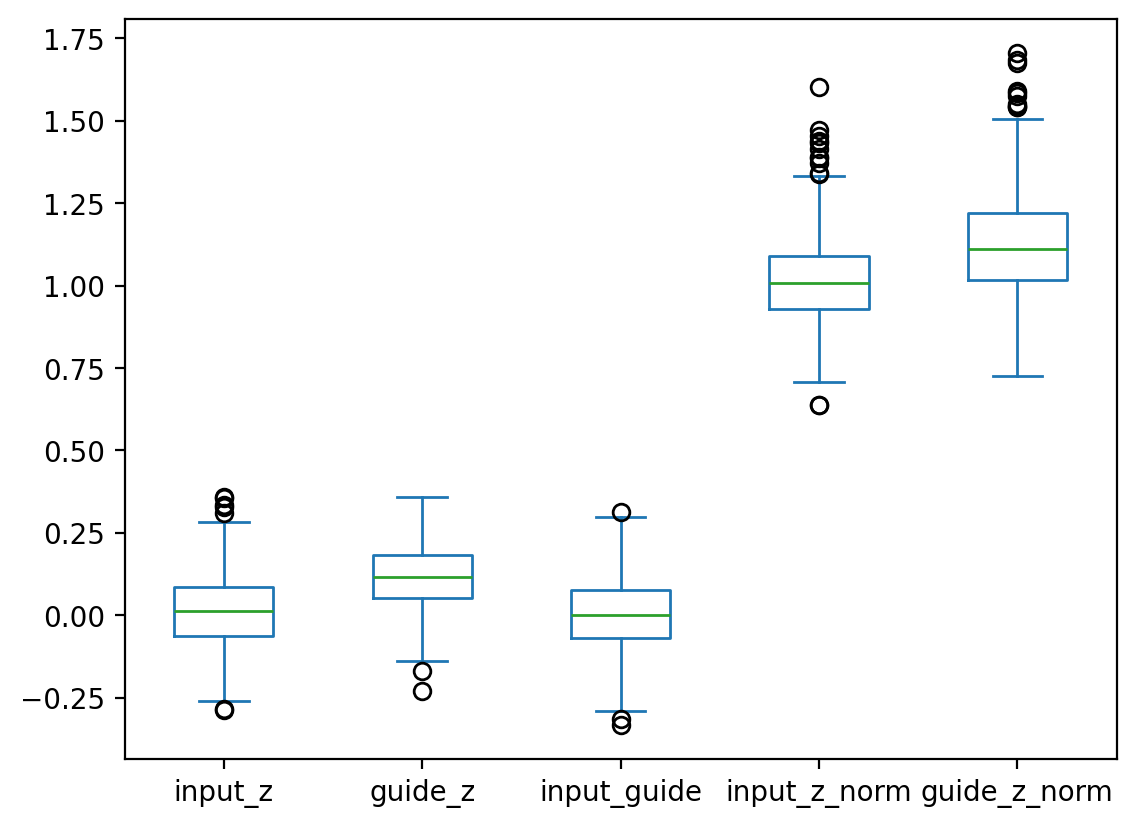

In [54]:
ax = res.plot(kind='box')
plt.savefig(results_folder + base_name + '_' + str(p < 0.01) + '.png', dpi=300)